In [1]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f">> Using device: {device}")

>> Using device: cuda


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder
import time
from IPython.display import HTML

# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Basic Environment setup

In [3]:
import gym
import time
import os

# Create the environment
env = gym.make('CartPole-v1')

print("Observation space: ", env.observation_space)

print("Action: ", env.action_space)

s = env.reset()
a = env.action_space.sample()
print('sample state [cart_position, cart_velocity, pole_angle, pole_velocity_at_tip]:\n', s)
print('sample action:', a )

# Create a folder to save the video
if not os.path.exists('videos'):
    os.makedirs('videos')

# Start the video recording
subdir = "setup"
env = gym.wrappers.Monitor(env, 'videos/' + subdir, video_callable=lambda episode_id: True, force=True)

# Run the loop
state = env.reset()
print("\nInitial state: ", observation)
done = False
# while not done:
i = 0
while (i<5):
    env.render()
    time.sleep(0.01)
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
#     print("Next state: ", observation)
#     print("Done: ", done)
    if done:
        i += 1
        print(i)
        env.reset()

Observation space:  Box(4,)
Action:  Discrete(2)
sample state [cart_position, cart_velocity, pole_angle, pole_velocity_at_tip]:
 [-0.01581622 -0.01284894  0.0282455   0.01793307]
sample action: 0


NameError: name 'observation' is not defined

Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either: 
1. is more than 15 degrees from vertical, 
2. more outside of the frame or 
3. the pole is successfully balanced for some fixed duration.

In [54]:
# Play the video
from IPython.display import HTML

video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" +video_names[0]))

['openaigym.video.23.103025.video000000.mp4', 'openaigym.video.23.103025.video000001.mp4', 'openaigym.video.23.103025.video000002.mp4', 'openaigym.video.23.103025.video000003.mp4', 'openaigym.video.23.103025.video000004.mp4', 'openaigym.video.23.103025.video000005.mp4']


In [4]:
# Close the environment
env.close()

## Policy Network

In [5]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

## Functions

In [6]:
def train(num_episodes, rollout_limit, discount_factor, learning_rate, val_freq, policy, subdir):
    # Create the environment
    env = gym.make('CartPole-v1')

    # Create a folder to save the video
    if not os.path.exists('videos'):
        os.makedirs('videos')

    # Start the video recording
    subdir = subdir
    env = gym.wrappers.Monitor(env, 'videos/' + subdir, video_callable=lambda episode_id: episode_id%100==True, force=True)
    
    # train policy network
    try:
        training_rewards, losses = [], []
        mean_val_rewards = []
        print('start training')
        start = time.time()

        for i in range(num_episodes):
            rollout = []
            s = env.reset()
            for j in range(rollout_limit):
                # generate rollout by iteratively evaluating the current policy on the environment
                with torch.no_grad():
                    s = s.astype('float64')
                    t1 = np.atleast_2d(s)
                    t2 = torch.from_numpy(t1).float()
                    a_prob = policy(t2)
                    a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()

                s1, r, done, info = env.step(a)
                rollout.append((s, a, r))
                s = s1

                if done: break

            # prepare batch
            rollout = np.array(rollout, dtype=object)
            states = np.vstack(rollout[:,0])
            actions = np.vstack(rollout[:,1])
            rewards = np.array(rollout[:,2], dtype=float)
            returns = compute_returns(rewards, discount_factor)

            # policy gradient update
            policy.optimizer.zero_grad()
            a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
            loss = policy.loss(a_probs, torch.from_numpy(returns).float())
            loss.backward()
            policy.optimizer.step()

            # bookkeeping
            training_rewards.append(sum(rewards))
            losses.append(loss.item())
            

            # print
            if (i+1) % val_freq == 0:
                # validation
                validation_rewards = []
                for _ in range(10):
                    s = env.reset()
                    reward = 0
                    for _ in range(rollout_limit):
                        with torch.no_grad():
                            s = s.astype('float64')
                            t1 = np.atleast_2d(s)
                            t2 = torch.from_numpy(t1).float()
                            a_prob = policy(t2)
                            a = a_prob.argmax().item()
                        s, r, done, info = env.step(a)
                        reward += r
                        if done: break
                    validation_rewards.append(reward)
                duration = time.time() - start
                mean_val_reward = np.mean(validation_rewards)
                print('{:4d}. Duration: {:6.2f} \nmean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, 
                                                                                                                                             duration, 
                                                                                                                                             np.mean(training_rewards[-val_freq:]), 
                                                                                                                                             mean_val_reward, 
                                                                                                                                             np.mean(losses[-val_freq:])))
                mean_val_rewards.append(mean_val_reward)
                start = time.time()
        print('done')
        env.close()

    except KeyboardInterrupt:
        print('interrupt')    
        env.close()
        
    return training_rewards, mean_val_rewards, losses

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [8]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

## Policy gradient - default (0 sec)

In [22]:
env = gym.make("CartPole-v1")
subdir = "default"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

state shape: 4
action shape: 2


In [23]:
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

start training
 100. Duration:   1.84 
mean training reward:  19.90, mean validation reward:  10.50, mean loss:  7.2014
 200. Duration:   1.44 
mean training reward:  20.01, mean validation reward:  10.50, mean loss:  7.2471
 300. Duration:   1.81 
mean training reward:  26.67, mean validation reward:  22.20, mean loss:  9.5173
 400. Duration:   1.89 
mean training reward:  27.30, mean validation reward:  17.30, mean loss:  9.5798
 500. Duration:   1.99 
mean training reward:  26.69, mean validation reward:  26.70, mean loss:  9.3688
 600. Duration:   1.88 
mean training reward:  35.49, mean validation reward:  68.50, mean loss: 12.2324
 700. Duration:   1.50 
mean training reward:  29.63, mean validation reward:  25.20, mean loss: 10.1514
 800. Duration:   1.10 
mean training reward:  21.77, mean validation reward:  11.00, mean loss:  7.5148
done


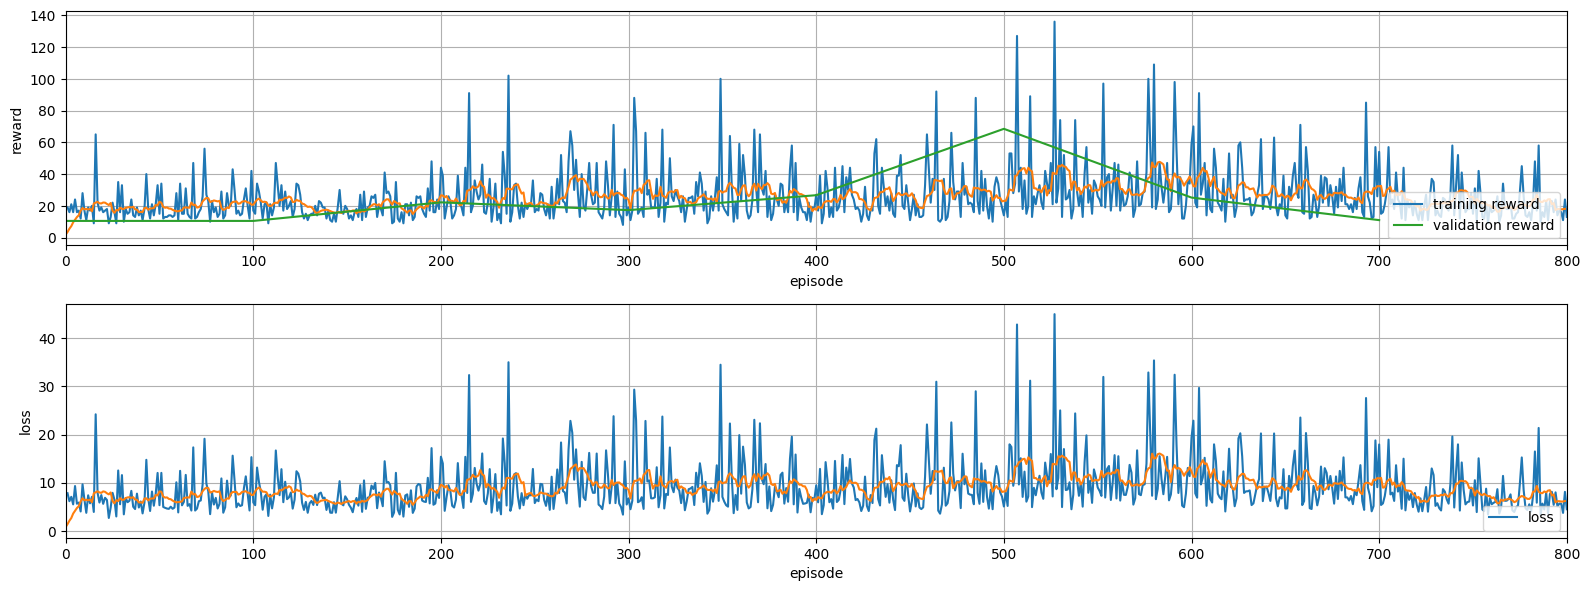

In [27]:
# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.plot(np.arange(0,num_episodes, val_freq), validation_rewards, label='validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

Now let's review the solution!

In [28]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.4.9915.video000001.mp4', 'openaigym.video.4.9915.video000101.mp4', 'openaigym.video.4.9915.video000201.mp4', 'openaigym.video.4.9915.video000301.mp4', 'openaigym.video.4.9915.video000401.mp4', 'openaigym.video.4.9915.video000501.mp4', 'openaigym.video.4.9915.video000601.mp4', 'openaigym.video.4.9915.video000701.mp4', 'openaigym.video.4.9915.video000801.mp4']


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers

### Number of episodes (7 sec)

In [14]:
env = gym.make("CartPole-v1")
subdir = "num_episodes_2000"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

state shape: 4
action shape: 2


In [15]:
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

start training
 100. Duration:   1.91 
mean training reward:  20.24, mean validation reward:   9.30, mean loss:  7.2341
 200. Duration:   1.32 
mean training reward:  18.62, mean validation reward:   9.30, mean loss:  6.5736
 300. Duration:   1.44 
mean training reward:  18.58, mean validation reward:   9.60, mean loss:  6.4099
 400. Duration:   1.49 
mean training reward:  20.22, mean validation reward:  10.70, mean loss:  7.1708
 500. Duration:   1.30 
mean training reward:  18.46, mean validation reward:   9.90, mean loss:  6.4270
 600. Duration:   1.81 
mean training reward:  19.82, mean validation reward:   9.60, mean loss:  6.9111
 700. Duration:   1.09 
mean training reward:  19.20, mean validation reward:   9.80, mean loss:  6.7764
 800. Duration:   1.03 
mean training reward:  20.89, mean validation reward:  10.00, mean loss:  7.3837
 900. Duration:   1.10 
mean training reward:  18.67, mean validation reward:   9.30, mean loss:  6.4673
1000. Duration:   1.03 
mean training re

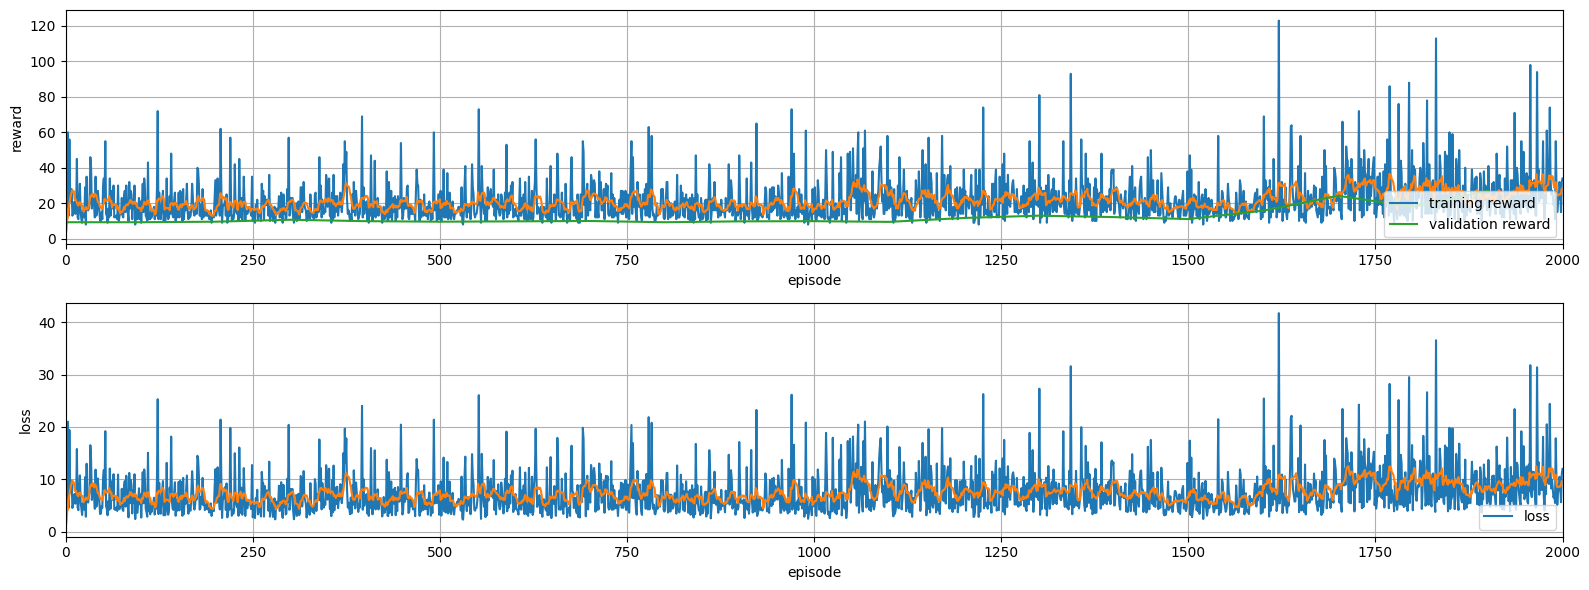

In [16]:
# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.plot(np.arange(0,num_episodes, val_freq), validation_rewards, label='validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

In [17]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.2.9915.video000001.mp4', 'openaigym.video.2.9915.video000101.mp4', 'openaigym.video.2.9915.video000201.mp4', 'openaigym.video.2.9915.video000301.mp4', 'openaigym.video.2.9915.video000401.mp4', 'openaigym.video.2.9915.video000501.mp4', 'openaigym.video.2.9915.video000601.mp4', 'openaigym.video.2.9915.video000701.mp4', 'openaigym.video.2.9915.video000801.mp4', 'openaigym.video.2.9915.video000901.mp4', 'openaigym.video.2.9915.video001001.mp4', 'openaigym.video.2.9915.video001101.mp4', 'openaigym.video.2.9915.video001201.mp4', 'openaigym.video.2.9915.video001301.mp4', 'openaigym.video.2.9915.video001401.mp4', 'openaigym.video.2.9915.video001501.mp4', 'openaigym.video.2.9915.video001601.mp4', 'openaigym.video.2.9915.video001701.mp4', 'openaigym.video.2.9915.video001801.mp4', 'openaigym.video.2.9915.video001901.mp4', 'openaigym.video.2.9915.video002001.mp4', 'openaigym.video.2.9915.video002101.mp4']


### Discount factor + number of episodes
- 0.9 - 0 sec
- 0.99 - 8 sec

In [18]:
env = gym.make("CartPole-v1")
subdir = "discount_factor"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 0.99 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

state shape: 4
action shape: 2


In [19]:
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

start training
 100. Duration:   1.92 
mean training reward:  20.40, mean validation reward:  49.60, mean loss:  6.6688
 200. Duration:   2.01 
mean training reward:  28.56, mean validation reward:  34.20, mean loss:  9.0704
 300. Duration:   2.02 
mean training reward:  28.46, mean validation reward:  22.50, mean loss:  8.8846
 400. Duration:   1.91 
mean training reward:  27.86, mean validation reward:  60.40, mean loss:  8.7869
 500. Duration:   1.90 
mean training reward:  29.92, mean validation reward:  54.70, mean loss:  9.2527
 600. Duration:   1.53 
mean training reward:  33.25, mean validation reward:  78.40, mean loss:  9.9809
 700. Duration:   1.56 
mean training reward:  33.31, mean validation reward:  45.50, mean loss:  9.9866
 800. Duration:   1.49 
mean training reward:  32.88, mean validation reward:  50.50, mean loss:  9.9578
 900. Duration:   1.38 
mean training reward:  31.02, mean validation reward:  23.20, mean loss:  9.3554
1000. Duration:   1.52 
mean training re

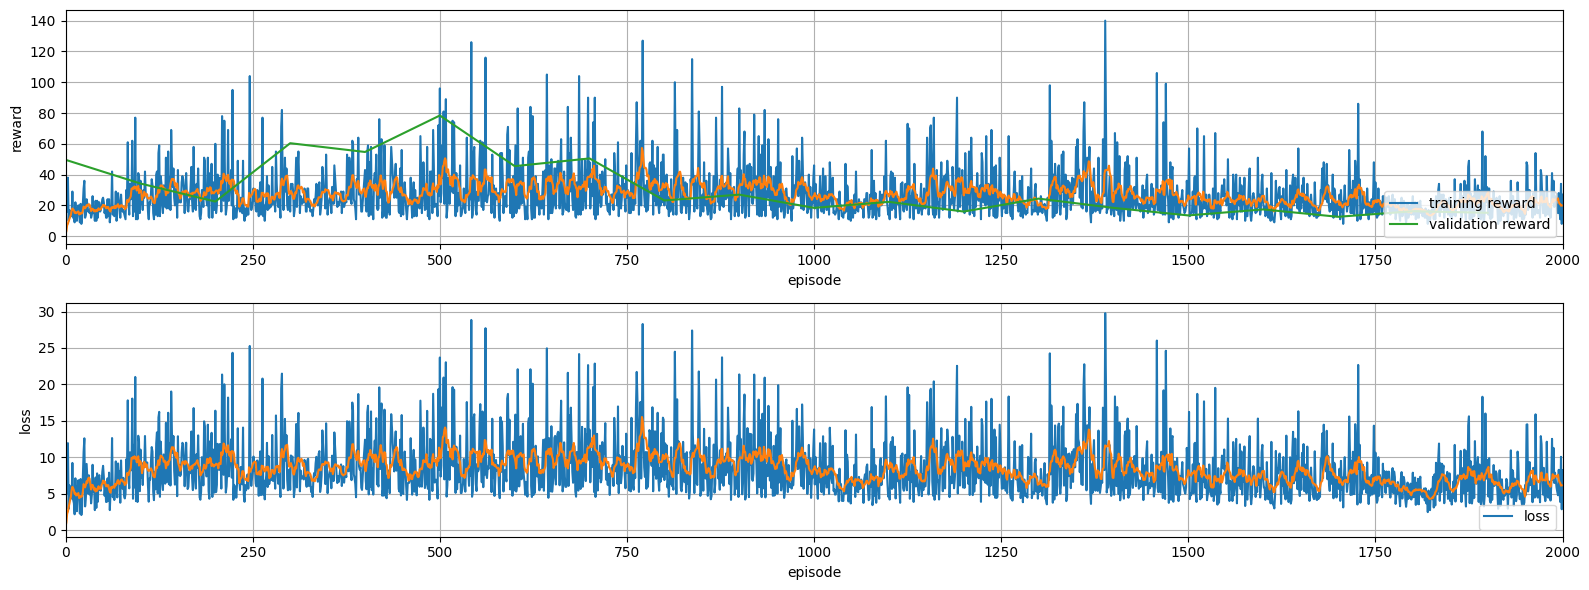

In [20]:
# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.plot(np.arange(0,num_episodes, val_freq), validation_rewards, label='validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

In [21]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.3.9915.video000001.mp4', 'openaigym.video.3.9915.video000101.mp4', 'openaigym.video.3.9915.video000201.mp4', 'openaigym.video.3.9915.video000301.mp4', 'openaigym.video.3.9915.video000401.mp4', 'openaigym.video.3.9915.video000501.mp4', 'openaigym.video.3.9915.video000601.mp4', 'openaigym.video.3.9915.video000701.mp4', 'openaigym.video.3.9915.video000801.mp4', 'openaigym.video.3.9915.video000901.mp4', 'openaigym.video.3.9915.video001001.mp4', 'openaigym.video.3.9915.video001101.mp4', 'openaigym.video.3.9915.video001201.mp4', 'openaigym.video.3.9915.video001301.mp4', 'openaigym.video.3.9915.video001401.mp4', 'openaigym.video.3.9915.video001501.mp4', 'openaigym.video.3.9915.video001601.mp4', 'openaigym.video.3.9915.video001701.mp4', 'openaigym.video.3.9915.video001801.mp4', 'openaigym.video.3.9915.video001901.mp4', 'openaigym.video.3.9915.video002001.mp4', 'openaigym.video.3.9915.video002101.mp4']


### Learning Rate + num_episodes
- 0.0001 - 0 sec
- 0.01 - 0 sec

state shape: 4
action shape: 2
start training
 100. Duration:   2.16 
mean training reward:  31.34, mean validation reward: 228.50, mean loss: 10.5830
 200. Duration:   2.19 
mean training reward:  65.63, mean validation reward:  67.60, mean loss: 17.7615
 300. Duration:   2.78 
mean training reward:  86.71, mean validation reward: 239.60, mean loss: 20.1308
 400. Duration:   2.33 
mean training reward:  87.43, mean validation reward:  66.10, mean loss: 17.7363
 500. Duration:   3.76 
mean training reward: 113.76, mean validation reward: 184.80, mean loss: 21.7012
 600. Duration:   7.27 
mean training reward: 270.51, mean validation reward: 238.30, mean loss: 52.9497
 700. Duration:   7.26 
mean training reward: 220.87, mean validation reward: 342.50, mean loss: 31.9560
 800. Duration:  11.03 
mean training reward: 281.70, mean validation reward: 135.80, mean loss: 44.3613
 900. Duration:   3.35 
mean training reward: 113.60, mean validation reward: 135.50, mean loss: 13.5659
1000. Dur

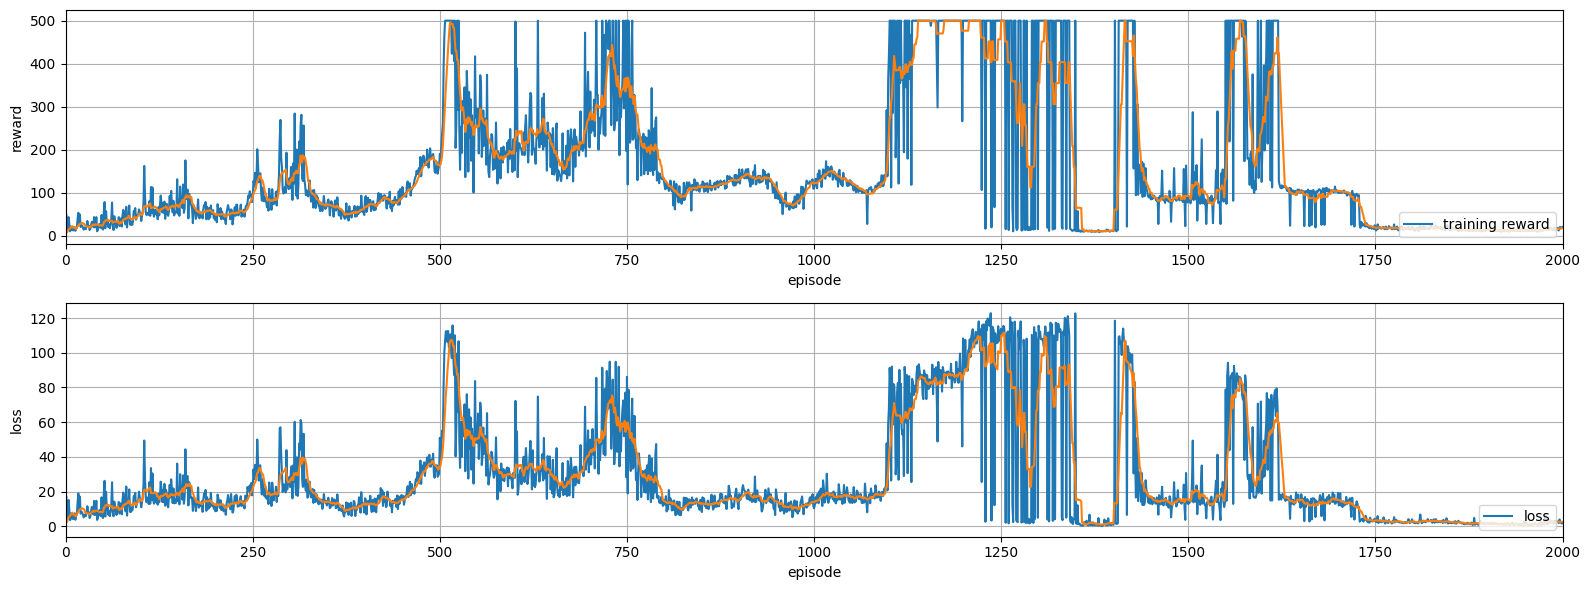

In [125]:
env = gym.make("CartPole-v1")
subdir = "learning_rate"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train network
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

In [126]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.34.103025.video000001.mp4', 'openaigym.video.34.103025.video000101.mp4', 'openaigym.video.34.103025.video000201.mp4', 'openaigym.video.34.103025.video000301.mp4', 'openaigym.video.34.103025.video000401.mp4', 'openaigym.video.34.103025.video000501.mp4', 'openaigym.video.34.103025.video000601.mp4', 'openaigym.video.34.103025.video000701.mp4', 'openaigym.video.34.103025.video000801.mp4', 'openaigym.video.34.103025.video000901.mp4', 'openaigym.video.34.103025.video001001.mp4', 'openaigym.video.34.103025.video001101.mp4', 'openaigym.video.34.103025.video001201.mp4', 'openaigym.video.34.103025.video001301.mp4', 'openaigym.video.34.103025.video001401.mp4', 'openaigym.video.34.103025.video001501.mp4', 'openaigym.video.34.103025.video001601.mp4', 'openaigym.video.34.103025.video001701.mp4', 'openaigym.video.34.103025.video001801.mp4', 'openaigym.video.34.103025.video001901.mp4', 'openaigym.video.34.103025.video002001.mp4', 'openaigym.video.34.103025.video002101.mp4']


### Number of layers + num_episodes (10 sec)
- Deeper network doesn't necessarily lead to better or worse results, there is a sweet spot

In [209]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_outputs)
        )
        
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [210]:
env = gym.make("CartPole-v1")
subdir = "num_layers"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train network
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

state shape: 4
action shape: 2
start training
 100. Duration:   1.46 
mean training reward:  20.48, mean validation reward:  10.90, mean loss:  7.4956
 200. Duration:   0.80 
mean training reward:  22.94, mean validation reward:  16.00, mean loss:  8.2969
 300. Duration:   1.50 
mean training reward:  28.68, mean validation reward:  68.40, mean loss: 10.2042
 400. Duration:   1.29 
mean training reward:  30.12, mean validation reward:  42.80, mean loss: 10.5760
 500. Duration:   1.15 
mean training reward:  29.44, mean validation reward:  82.40, mean loss: 10.2604
 600. Duration:   1.08 
mean training reward:  34.85, mean validation reward:  80.80, mean loss: 12.0358
 700. Duration:   1.36 
mean training reward:  41.93, mean validation reward: 104.40, mean loss: 14.2055
 800. Duration:   1.54 
mean training reward:  39.47, mean validation reward: 122.00, mean loss: 13.3887
 900. Duration:   1.27 
mean training reward:  36.26, mean validation reward: 124.00, mean loss: 12.3343
1000. Dur

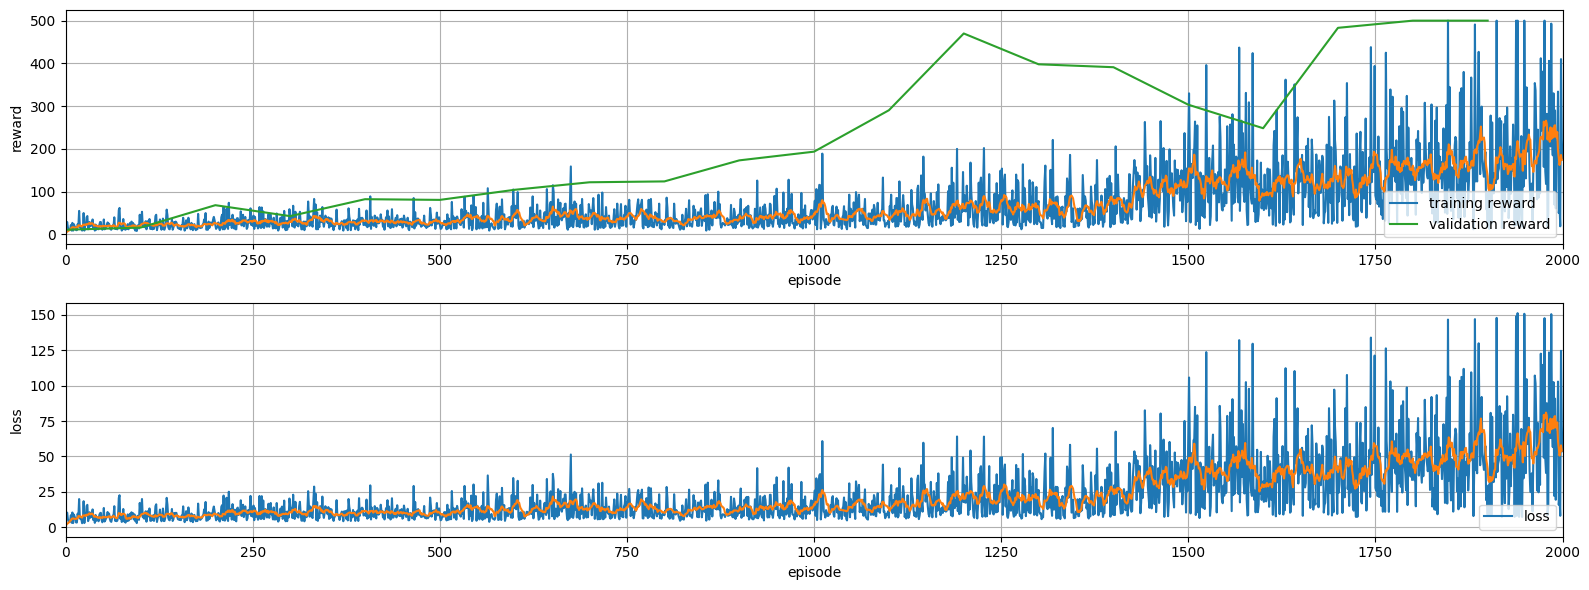

In [211]:
# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.plot(np.arange(0,num_episodes, val_freq), validation_rewards, label='validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

In [213]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.48.103025.video000001.mp4', 'openaigym.video.48.103025.video000101.mp4', 'openaigym.video.48.103025.video000201.mp4', 'openaigym.video.48.103025.video000301.mp4', 'openaigym.video.48.103025.video000401.mp4', 'openaigym.video.48.103025.video000501.mp4', 'openaigym.video.48.103025.video000601.mp4', 'openaigym.video.48.103025.video000701.mp4', 'openaigym.video.48.103025.video000801.mp4', 'openaigym.video.48.103025.video000901.mp4', 'openaigym.video.48.103025.video001001.mp4', 'openaigym.video.48.103025.video001101.mp4', 'openaigym.video.48.103025.video001201.mp4', 'openaigym.video.48.103025.video001301.mp4', 'openaigym.video.48.103025.video001401.mp4', 'openaigym.video.48.103025.video001501.mp4', 'openaigym.video.48.103025.video001601.mp4', 'openaigym.video.48.103025.video001701.mp4', 'openaigym.video.48.103025.video001801.mp4', 'openaigym.video.48.103025.video001901.mp4', 'openaigym.video.48.103025.video002001.mp4', 'openaigym.video.48.103025.video002101.mp4']


### Loss (NLL loss) + number of layer + num_episodes

In [9]:
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [10]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.rnn = nn.Sequential(
            nn.RNN(64, 16),
            SelectItem(0)
        )
        
        self.output = nn.Sequential(
            nn.Linear(16, n_outputs)
        )
        
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
#         print(x.shape)
        x = self.hidden(x)
#         print(x.shape)
        x = self.rnn(x)
#         print(x.shape)
        x = self.output(x)
#         print(x.shape)
        
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [11]:
env = gym.make("CartPole-v1")
subdir = "num_layers"

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

env.close()

# training settings
num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train network
training_rewards, validation_rewards, losses = train(num_episodes, 
                                                     rollout_limit, 
                                                     discount_factor, 
                                                     learning_rate, 
                                                     val_freq, 
                                                     policy, 
                                                     subdir)

state shape: 4
action shape: 2
start training
 100. Duration:   2.49 
mean training reward:  25.86, mean validation reward:  53.50, mean loss:  9.2894
 200. Duration:   2.08 
mean training reward:  30.28, mean validation reward:  76.50, mean loss: 10.6200
 300. Duration:   2.30 
mean training reward:  30.94, mean validation reward:  98.80, mean loss: 10.8082
 400. Duration:   2.51 
mean training reward:  32.34, mean validation reward:  58.40, mean loss: 11.1614
 500. Duration:   1.70 
mean training reward:  36.93, mean validation reward:  93.10, mean loss: 12.6127
 600. Duration:   2.22 
mean training reward:  39.31, mean validation reward: 124.70, mean loss: 13.2768
 700. Duration:   2.41 
mean training reward:  41.30, mean validation reward: 239.10, mean loss: 13.9621
 800. Duration:   2.03 
mean training reward:  38.36, mean validation reward: 127.30, mean loss: 13.0121
 900. Duration:   1.96 
mean training reward:  40.72, mean validation reward: 165.00, mean loss: 13.6672
1000. Dur

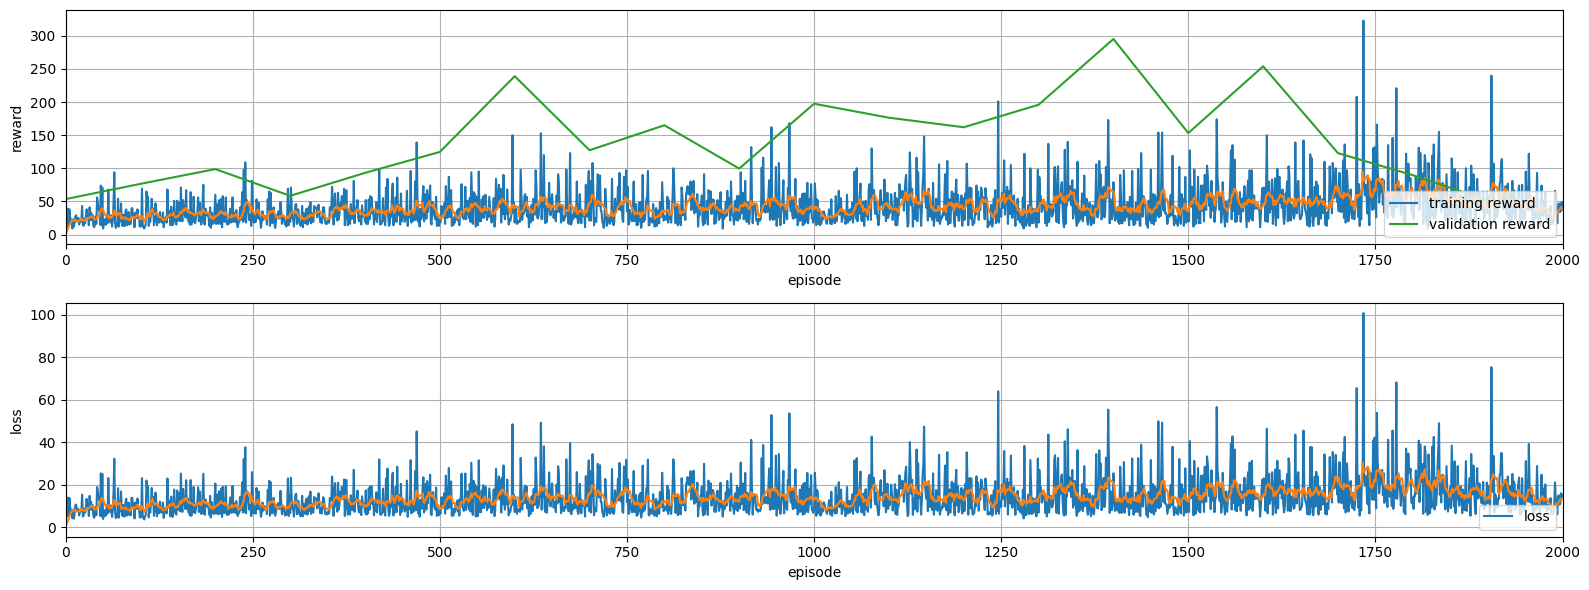

In [12]:
# plot results
plt.figure(figsize=(16,6))

plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.plot(np.arange(0,num_episodes, val_freq), validation_rewards, label='validation reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

In [13]:
# Play the video
video_names = sorted(list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/" + subdir))))
print(video_names)
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + subdir +"/" + video_names[-1]))

['openaigym.video.1.9915.video000001.mp4', 'openaigym.video.1.9915.video000101.mp4', 'openaigym.video.1.9915.video000201.mp4', 'openaigym.video.1.9915.video000301.mp4', 'openaigym.video.1.9915.video000401.mp4', 'openaigym.video.1.9915.video000501.mp4', 'openaigym.video.1.9915.video000601.mp4', 'openaigym.video.1.9915.video000701.mp4', 'openaigym.video.1.9915.video000801.mp4', 'openaigym.video.1.9915.video000901.mp4', 'openaigym.video.1.9915.video001001.mp4', 'openaigym.video.1.9915.video001101.mp4', 'openaigym.video.1.9915.video001201.mp4', 'openaigym.video.1.9915.video001301.mp4', 'openaigym.video.1.9915.video001401.mp4', 'openaigym.video.1.9915.video001501.mp4', 'openaigym.video.1.9915.video001601.mp4', 'openaigym.video.1.9915.video001701.mp4', 'openaigym.video.1.9915.video001801.mp4', 'openaigym.video.1.9915.video001901.mp4', 'openaigym.video.1.9915.video002001.mp4', 'openaigym.video.1.9915.video002101.mp4']


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**
- default: 16 sec, 

- num_episodes: 800 -> 1200 : 16 sec -> 16 sec

The agent has more opportunities to explore the environment and learn from a wider range of experiences. This can lead to better performance as the agent is able to learn more about the dynamics of the environment and the optimal actions to take in different situations. Additionally, increasing the number of episodes also allows the agent to see more long-term consequences of its actions, which is useful because the optimal action depends on the future state of the environment.

- discount_factor: 1 -> 0.9 (800 episodes) : The loss starts dropping, instead of increasing, and the the stick is stable for ~0 seconds.

This makes sense, as the agent starts valuing the immediate rewards more than the future ones. However, we do not want that. Overreacting and correcting the pole too much will lead to it going in an uncontrollable state.

- learning rate:
    - 0.1: Loss goes to 0, 2 sec -> 0 seconds
    - 0.0001: Loss stays the same over the training, 2 sec -> 1 sec

- number of layers:
    - 



### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

1. The total reward is 5 and it is derived by summing the rewards.
2. In each timestep [0, 1, 2, 3, 3, 4, 5, 5, 5, 5] the total future reward is derived by accumulating the rewards in each timestep.
3. The discounted future reward in each timestep is [0,0.9,1.71,2.44,2.44,3.03,3.56,3.56,3.56,3.56). The result is calcualated by:
$$R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T} r_T = \sum_{k=0}^{T-t} \gamma^k r_{t+k} \ 
$$

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

During the initial stages of training, the agent is still exploring and learning the dynamics of the environment. As training progresses, the agent becomes more specialized to the training environment and starts to exploit the learned policy, causing the training reward to increase. However, this policy may not generalize well to unseen environments, causing the validation reward to be lower.

As training continues, the agent becomes more specialized to the training environment and generalizes poorly to unseen environments, causing the gap between the training and validation rewards to widen. This is the overfitting phase.

When the validation reward becomes higher than the training reward, it indicates that the agent has stopped overfitting and has started generalizing well to unseen environments. This is because the agent has learned a policy that is robust enough to generalize to unseen environments.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

During the training step, the probabilities of the left and right action are computed. Afterwards, the action takes place by sampling from a multinomial distribution

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

# Training moved to cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# training settings

num_episodes = 1800
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)
if cuda:
    policy = policy.cuda()

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                _ = torch.from_numpy(np.atleast_2d(s)).float().to(device)
                a_prob = policy(_)
                a_prob = a_prob.cpu()
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout, dtype=object)
        states = np.vstack(rollout[:,0])
        states = torch.from_numpy(states).float().to(device)
        actions = np.vstack(rollout[:,1])
        actions = torch.from_numpy(actions).float().to(device)
        actions = actions.to(torch.int64)
        rewards = np.array(rollout[:,2], dtype=float)
        rewards = torch.from_numpy(rewards).float().to(device)
        returns = compute_returns(rewards, discount_factor)
        returns = torch.from_numpy(returns).float().to(device)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(states).gather(1, actions).view(-1)
        # a_probs = policy(torch.from_numpy(states)).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, returns)
        loss = loss.cuda()
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards.cpu()))
        losses.append(loss.cpu().item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float().to(device))
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print("\tEpisode: {:4d}. \nmean training reward: {:6.2f}".format(i+1, np.mean(training_rewards[-val_freq:])))
            print("mean validation reward: {:6.2f}".format(np.mean(validation_rewards)))
            print("mean loss: {:7.4f}".format(np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

In [ ]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
# env.close()
env.play()